In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import ResNet50_Weights
# Load a pretrained model
import cv2
model = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
model.eval();  # Set the model to evaluation mode

In [2]:
def preprocess_image(img_path):
    """Preprocess an image for the model."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Replace 'path_to_your_image.jpg' with the path to the image you want to use
image_path = 'C:\\Users\\guoyy\\OneDrive\\Desktop\\computer vision\\HW\\rawdata\\minicatdog\\train\cat.0.jpg'
image = preprocess_image(img_path = image_path)

In [3]:
# learning some torch_snippet later

In [4]:
image.shape

torch.Size([1, 3, 224, 224])

In [7]:
from torch.autograd import Function

class GradCAM:
    """Implements Grad-CAM."""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.forward_output = None
        
        # Hook the target layer
        target_layer.register_forward_hook(self.save_forward_output_hook)
        target_layer.register_full_backward_hook(self.save_gradients_hook)
    
    def save_forward_output_hook(self, module, input, output):
        self.forward_output = output
    
    def save_gradients_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def __call__(self, x, index=None):
        self.model.zero_grad()
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)
        
        guided_gradients = self.gradients.cpu().data.numpy()[0]
        target = self.forward_output.cpu().data.numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Choose the target layer you want to visualize
target_layer = model.layer4[1].conv2

# Create a Grad-CAM object
grad_cam = GradCAM(model, target_layer)

# Get the class activation map
cam = grad_cam(image)

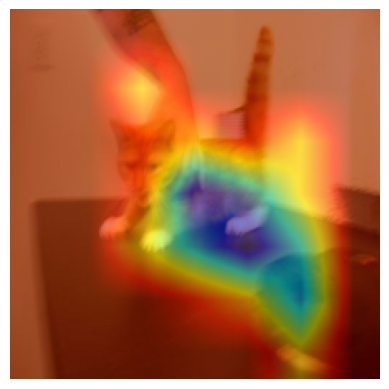

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_cam(image_path, cam):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    # Resize the CAM to match the image size
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    
    # Convert heatmap to float32 and normalize it
    heatmap = np.float32(heatmap) / 255
    
    # Overlay the heatmap on the image
    overlayed_img = heatmap + np.float32(img) / np.max(np.float32(img))
    
    # Normalize the result
    overlayed_img = overlayed_img / np.max(overlayed_img)
    
    # Show the image
    plt.imshow(np.uint8(255 * overlayed_img))
    plt.axis('off')  # Hide the axis
    plt.show()

# Assuming 'cam' is your Class Activation Map and 'path_to_your_image.jpg' is the path to your image
display_cam(image_path, cam)
